In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import logging
import matplotlib.pyplot as plt
import json
import pickle
from itertools import product
from tqdm import tqdm
import numpy as np

# Add the project root to the system path using the current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import using absolute path from project root
from src.instances.chain_instance import ARBITRUM_DTO, OPTIMISM_DTO, ETHEREUM_DTO, BASE_DTO
from src.instances.aave_instance import AaveArbitrum, AaveOptimism, AaveEthereum, AaveBase
from src.models.token import TokenDTO
from src.models.trade_pair import PairDTO


2024-12-13 14:28:06,840 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Arbitrum
2024-12-13 14:28:06,841 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Optimism
2024-12-13 14:28:06,841 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Ethereum
2024-12-13 14:28:06,842 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Base


In [3]:
from src.scripts.process_stored_data_aave import update_trade_pair_exchange_price, \
    create_liquidatable_user_data_series, create_health_ratio_data_emode, create_asset_mapping, \
    create_health_ratio_data, create_liquidatable_user_data, scale_supply_and_create_liquidations, \
    create_liquidations_v2, scale_price_and_identify_liquidatable_collateral


In [4]:
chain_object_mapping = {
    'ethereum': [ETHEREUM_DTO, AaveEthereum],
    'arbitrum': [ARBITRUM_DTO, AaveArbitrum],
    'optimism': [OPTIMISM_DTO, AaveOptimism],
    'base': [BASE_DTO, AaveBase]
}

In [5]:
CHOOSEN_CHAIN = 'ethereum'
AAVE_EMODE_LT = 0.95
ASSET_UNDER_CONSIDERATION = "WBTC"
EMODE_SWITCH = True
ASSET_UNDER_CONSIDERATION_CURVE = 'WBTC'
SOFT_LIQUIDATION_EFFICIENCY = 0.80
PRICE_DROP_FACTOR = 0.85



if CHOOSEN_CHAIN not in chain_object_mapping:
    print("Invalid chain chosen.")
    exit(1)
else:
    chain_instance, aave_instance = chain_object_mapping[CHOOSEN_CHAIN]


In [6]:
if not os.path.exists('aave_supported_asset_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_supported_asset_data = aave_instance.get_aave_supported_asset_data()
    print("Saving to file.")
    aave_supported_asset_data.to_csv('aave_supported_asset_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_supported_asset_data = pd.read_csv('aave_supported_asset_data.csv')


File found. Reading from file.


In [7]:
if not os.path.exists('aave_user_position_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_user_position_data = aave_instance.get_user_position_data(aave_supported_asset_data)
    print("Saving to file.")
    aave_user_position_data.to_csv('aave_user_position_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_user_position_data = pd.read_csv('aave_user_position_data.csv')


if not EMODE_SWITCH:
    # Filter out 0 from emode column
    aave_user_position_data = aave_user_position_data[aave_user_position_data['emode'] == 0]

File found. Reading from file.


In [8]:
aave_asset_object_dict = {}

for _, row in tqdm(aave_supported_asset_data.iterrows(), total=len(aave_supported_asset_data), desc="Creating TokenDTO objects"):
    token = TokenDTO(
        address=row['assetAddress'],
        name=row['symbol'],
        symbol=row['symbol'],
        decimals=row['decimals'],
        chain=chain_instance,
        price=row['price'],
    )
    aave_asset_object_dict[row['symbol']] = token

Creating TokenDTO objects: 100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


In [9]:
current_price_mapping = {}
for index, asset in aave_supported_asset_data.iterrows():
    current_price_mapping[asset['symbol']] = asset['price']

In [10]:
# liquidatable_price_df = scale_price_and_identify_liquidatable_collateral(aave_supported_asset_data, 
#                                                             aave_user_position_data, 
#                                                             current_price_mapping, 
#                                                             AAVE_EMODE_LT, 
#                                                             ASSET_UNDER_CONSIDERATION,
#                                                             0.5, 
#                                                             30)



In [11]:
# # plot scale and liquidatable_collateral
# plt.figure(figsize=(16, 8))
# plt.plot(liquidatable_price_df['price'], liquidatable_price_df['liquidatable_collateral'], label='Liquidatable Collateral')
# plt.xlabel('Price')
# plt.ylabel('Liquidatable Collateral')
# plt.title('Liquidatable Collateral vs Scale')
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.7)
# plt.show()

## Curve user positions

In [12]:
from src.instances.curve_mint_market_instance import market_objects_dict


In [13]:
market = market_objects_dict[ASSET_UNDER_CONSIDERATION_CURVE]
df = market.get_user_position_data()

In [17]:
output_liq_df, output_liq_df_raw = market.compute_price_for_max_hard_liq(df, SOFT_LIQUIDATION_EFFICIENCY)

In [18]:
output_liq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_price             10 non-null     float64
 1   max_collateral_value  10 non-null     float64
 2   debt                  10 non-null     float64
dtypes: float64(3)
memory usage: 372.0 bytes


In [19]:
# # Convert liquidatable_price_df's cumulative values to absolute values
# liquidatable_price_abs_df = liquidatable_price_df.copy()
# liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=True)  # Sort ascending first
# liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)  # Reset index after sorting

# # Calculate differences from bottom up
# liquidatable_price_abs_df['liquidatable_collateral_abs'] = liquidatable_price_abs_df['liquidatable_collateral'].diff(-1)
# # Fill the last row with its liquidatable_collateral value since it's the base value
# liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral_abs'] = liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral']

# # Sort back to descending order for the rest of the processing
# liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=False)
# liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)

# # Create new dataframes with renamed columns for clarity
# df1 = output_liq_df[['max_price', 'max_collateral_value']].rename(
#     columns={'max_price': 'price', 'max_collateral_value': 'liquidatable_collateral_abs'})
# df2 = liquidatable_price_abs_df[['price', 'liquidatable_collateral_abs']]

# # Concatenate the dataframes
# combined_df = pd.concat([df1, df2], ignore_index=True)

# # Sort by price in descending order
# combined_df = combined_df.sort_values('price', ascending=False)

# # Create cumulative sum column
# combined_df['cumulative_liquidatable_collateral'] = combined_df['liquidatable_collateral_abs'].cumsum()

# # Reset index after sorting
# combined_df = combined_df.reset_index(drop=True)

In [20]:
# # plot scale and liquidatable_collateral
# plt.figure(figsize=(16, 8))
# plt.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], label='Liquidatable Collateral')
# plt.xlabel('Price')
# plt.ylabel('Liquidatable Collateral')
# plt.title('Liquidatable Collateral vs Scale')
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.7)
# plt.show()

In [21]:
# # Calculate first and second derivatives
# first_derivative = np.gradient(combined_df['cumulative_liquidatable_collateral'], combined_df['price'])
# second_derivative = np.gradient(first_derivative, combined_df['price'])

# # Create subplots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24))

# # Plot original function
# ax1.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], 'b-', label='Liquidatable Collateral')
# ax1.set_xlabel('Price')
# ax1.set_ylabel('Liquidatable Collateral')
# ax1.set_title('Original Function')
# ax1.grid(True, linestyle=':', alpha=0.7)
# ax1.legend()

# # Plot first derivative
# ax2.plot(combined_df['price'], first_derivative, 'r-', label='First Derivative')
# ax2.set_xlabel('Price')
# ax2.set_ylabel('Rate of Change')
# ax2.set_title('First Derivative')
# ax2.grid(True, linestyle=':', alpha=0.7)
# ax2.legend()

# # Plot second derivative
# ax3.plot(combined_df['price'], second_derivative, 'g-', label='Second Derivative')
# ax3.set_xlabel('Price')
# ax3.set_ylabel('Rate of Change of Rate of Change')
# ax3.set_title('Second Derivative')
# ax3.grid(True, linestyle=':', alpha=0.7)
# ax3.legend()

# plt.tight_layout()
# plt.show()

---

In [22]:
# Find value from aave_asset_object_dict where the key is the same as ASSET_UNDER_CONSIDERATION
asset_object = next((value for key, value in aave_asset_object_dict.items() if key == ASSET_UNDER_CONSIDERATION), None)


In [23]:
PRICE_ASSUMPTION = PRICE_DROP_FACTOR*asset_object.price


In [24]:
PRICE_ASSUMPTION

82473.8

In [25]:
def get_curve_liquidation_data(output_liq_df: pd.DataFrame, price_assumption: float) -> tuple[float, float]:
    """
    Get curve liquidation data for the closest price point >= price_assumption.
    Returns (collateral, debt) tuple or (None, None) if no suitable price found.
    """
    # Check if there are any prices >= price_assumption
    valid_rows = output_liq_df[output_liq_df['max_price'] <= price_assumption]
    
    if valid_rows.empty:
        return None, None
    
    # Get the closest row
    closest_row = valid_rows.sort_values('max_price').iloc[-1]
    return {ASSET_UNDER_CONSIDERATION_CURVE:float(closest_row['max_collateral_value'])}, {'crvUSD':float(closest_row['debt'])}


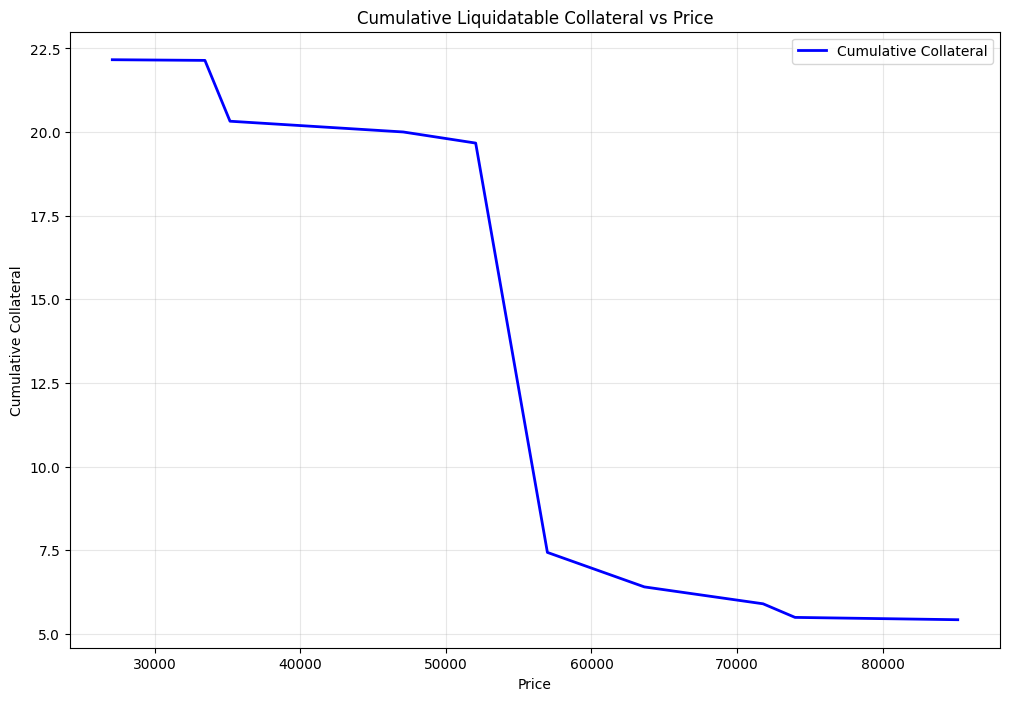

In [26]:
# Create a copy and sort by max_price in descending order
plot_df = output_liq_df.copy()
plot_df = plot_df.sort_values('max_price', ascending=False)

# Add cumulative sum column
plot_df['cum_collateral'] = plot_df['max_collateral_value'].cumsum()

plot_df['cum_debt'] = plot_df['debt'].cumsum()

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(plot_df['max_price'], plot_df['cum_collateral'], 
         label='Cumulative Collateral', 
         color='blue',
         linewidth=2)

plt.xlabel('Price')
plt.ylabel('Cumulative Collateral')
plt.title('Cumulative Liquidatable Collateral vs Price')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [27]:
curve_collateral, curve_debt = get_curve_liquidation_data(output_liq_df, PRICE_ASSUMPTION)

In [46]:
print("Curve Liquidatable Collateral:")
print(json.dumps(curve_collateral, indent=4))
print("\nCurve Liquidatable Debt:")
print(json.dumps(curve_debt, indent=4))

Curve Liquidatable Collateral:
{
    "WBTC": 0.06947636
}

Curve Liquidatable Debt:
{
    "crvUSD": 5081.684511756271
}


In [28]:
def analyze_liquidatable_positions(
    aave_supported_asset_data: pd.DataFrame,
    aave_user_position_data: pd.DataFrame,
    asset_under_consideration: str,
    price_assumption: float,
    emode_lt: float,
    min_usd_threshold: float = 10000
) -> dict:
    """
    Analyzes liquidatable positions for given asset and price assumption.
    Returns both raw and USD values for liquidatable collateral and debt.
    """
    # Create price mapping
    new_price_mapping = {asset_under_consideration: price_assumption}
    price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))
    
    # Create asset mapping and get health ratios
    asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)
    
    # Get health ratio data for both normal and emode
    health_ratio_data_no_emode = create_health_ratio_data(aave_user_position_data, asset_mapping)
    health_ratio_data_emode = create_health_ratio_data_emode(aave_user_position_data, asset_mapping, emode_lt)
    health_ratio_data = pd.concat([health_ratio_data_no_emode, health_ratio_data_emode])
    
    # Get liquidatable positions
    total_liquidatable_collateral, total_liquidatable_debt = create_liquidatable_user_data(health_ratio_data)
    
    # Filter non-zero positions
    total_liquidatable_collateral = {k: v for k, v in total_liquidatable_collateral.items() if v > 0}
    total_liquidatable_debt = {k: v for k, v in total_liquidatable_debt.items() if v > 0}
    
    # Convert to USD
    total_liquidatable_collateral_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_collateral.items()
    }
    
    total_liquidatable_debt_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_debt.items()
    }
    
    # Filter by USD threshold
    filtered_collateral_usd = {k: v for k, v in total_liquidatable_collateral_usd.items() if v > min_usd_threshold}
    filtered_debt_usd = {k: v for k, v in total_liquidatable_debt_usd.items() if v > min_usd_threshold}
    
    # Reconstruct raw values from filtered USD values
    filtered_collateral = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_collateral_usd.items()
    }
    
    filtered_debt = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_debt_usd.items()
    }
    
    return filtered_collateral, filtered_debt

In [29]:
aave_collateral, aave_debt = analyze_liquidatable_positions(
    aave_supported_asset_data,
    aave_user_position_data,
    ASSET_UNDER_CONSIDERATION,
    PRICE_ASSUMPTION,
    AAVE_EMODE_LT
)

aave_collateral

{'WETH': 281.38250444526136, 'WBTC': 769.2027533099999}

In [30]:
def merge_liquidation_data(aave_data: dict, curve_data: dict) -> dict:
    """
    Merge liquidation data from Aave and Curve protocols.
    """
    merged_data = aave_data.copy()  # Start with Aave data
    
    # Merge Curve data
    for token, amount in curve_data.items():
        if token in merged_data:
            merged_data[token] += amount
        else:
            merged_data[token] = amount
    
    return merged_data


In [47]:
print("Aave Liquidatable Collateral:")
print(json.dumps(aave_collateral, indent=4))
print("\nAave Liquidatable Debt:")
print(json.dumps(aave_debt, indent=4))

Aave Liquidatable Collateral:
{
    "WETH": 281.38250444526136,
    "WBTC": 769.2027533099999
}

Aave Liquidatable Debt:
{
    "WETH": 199.40997276662276,
    "USDC": 3034762.8701979998,
    "DAI": 254412.18629800135,
    "USDT": 50588183.782884,
    "UNI": 735.7166216018554,
    "RPL": 2269.469508227577,
    "PYUSD": 433124.982113,
    "cbBTC": 8.724621
}


In [31]:
# Merge collateral data
total_collateral = merge_liquidation_data(aave_collateral, curve_collateral)

# Merge debt data
total_debt = merge_liquidation_data(aave_debt, curve_debt)

print("Total Liquidatable Collateral:")
print(json.dumps(total_collateral, indent=4))
print("\nTotal Liquidatable Debt:")
print(json.dumps(total_debt, indent=4))

Total Liquidatable Collateral:
{
    "WETH": 281.38250444526136,
    "WBTC": 769.2722296699999
}

Total Liquidatable Debt:
{
    "WETH": 199.40997276662276,
    "USDC": 3034762.8701979998,
    "DAI": 254412.18629800135,
    "USDT": 50588183.782884,
    "UNI": 735.7166216018554,
    "RPL": 2269.469508227577,
    "PYUSD": 433124.982113,
    "cbBTC": 8.724621,
    "crvUSD": 5081.684511756271
}


In [32]:
# Try to load existing trade_pair_hashmap or create new one
try:
    if os.path.exists('trade_pair_hashmap.pkl'):
        with open('trade_pair_hashmap.pkl', 'rb') as f:
            trade_pair_hashmap = pickle.load(f)
        print(f"Loaded existing trade_pair_hashmap with {len(trade_pair_hashmap)} pairs")
    else:
        trade_pair_hashmap = {}
        print("Created new empty trade_pair_hashmap")
except Exception as e:
    print(f"Error loading trade_pair_hashmap: {str(e)}")
    trade_pair_hashmap = {}
    print("Created new empty trade_pair_hashmap due to error")

Created new empty trade_pair_hashmap


In [33]:
# FLASHLOAN_ASSET_SYMBOLS = ['WETH']
FLASHLOAN_ASSET_SYMBOLS = ['USDC', 'USDT', 'DAI', 'WETH']

# Create sets for easier lookup
flashloan_assets = set(FLASHLOAN_ASSET_SYMBOLS)
liquidatable_debt_assets = set(total_debt.keys())
liquidatable_collateral_assets = set(total_collateral.keys())

# Function to create and store PairDTO if it doesn't exist
def create_and_store_pair(sell_token, buy_token, trade_pair_hashmap):
    if sell_token != buy_token:
        key = f"{sell_token}-{buy_token}"
        if key not in trade_pair_hashmap:
            
            print(f"Creating pair: {sell_token} -> {buy_token}")
            
            pair_dto = PairDTO(
                sell_token=aave_asset_object_dict[sell_token],
                buy_token=aave_asset_object_dict[buy_token],
                network=ETHEREUM_DTO
            )
            trade_pair_hashmap[key] = pair_dto
            return 1
    return 0

# Set 1: Flashloan assets as sell, liquidatable debt as buy
new_pairs_count = 0
total_pairs_set1 = len(flashloan_assets) * len(liquidatable_debt_assets)
for sell_token, buy_token in tqdm(product(flashloan_assets, liquidatable_debt_assets), 
                                  total=total_pairs_set1, 
                                  desc="Creating Set 1 PairDTO objects"):
    new_pairs_count += create_and_store_pair(sell_token, buy_token, trade_pair_hashmap)

# Set 2: Liquidatable collateral as sell, flashloan assets as buy
total_pairs_set2 = len(liquidatable_collateral_assets) * len(flashloan_assets)
for sell_token, buy_token in tqdm(product(liquidatable_collateral_assets, flashloan_assets), 
                                  total=total_pairs_set2, 
                                  desc="Creating Set 2 PairDTO objects"):
    new_pairs_count += create_and_store_pair(sell_token, buy_token, trade_pair_hashmap)

print(f"Total pairs in trade_pair_hashmap: {len(trade_pair_hashmap)}")
print(f"New pairs added: {new_pairs_count}")

# Save updated trade_pair_hashmap to a pickle file
import pickle
with open('trade_pair_hashmap.pkl', 'wb') as f:
    pickle.dump(trade_pair_hashmap, f)

Creating Set 1 PairDTO objects:   0%|          | 0/36 [00:00<?, ?it/s]

Creating pair: USDT -> DAI


Creating Set 1 PairDTO objects:   3%|▎         | 1/36 [00:39<23:08, 39.67s/it]

Creating pair: USDT -> USDC


Creating Set 1 PairDTO objects:   6%|▌         | 2/36 [01:18<22:13, 39.22s/it]

Creating pair: USDT -> RPL


Creating Set 1 PairDTO objects:   8%|▊         | 3/36 [01:55<21:04, 38.33s/it]

Creating pair: USDT -> WETH


Creating Set 1 PairDTO objects:  14%|█▍        | 5/36 [02:35<14:22, 27.81s/it]

Creating pair: USDT -> PYUSD


Creating Set 1 PairDTO objects:  17%|█▋        | 6/36 [03:10<14:56, 29.89s/it]

Creating pair: USDT -> crvUSD


Creating Set 1 PairDTO objects:  19%|█▉        | 7/36 [03:46<15:16, 31.62s/it]

Creating pair: USDT -> cbBTC


Creating Set 1 PairDTO objects:  22%|██▏       | 8/36 [04:21<15:16, 32.72s/it]

Creating pair: USDT -> UNI


Creating Set 1 PairDTO objects:  25%|██▌       | 9/36 [04:59<15:27, 34.34s/it]

Creating pair: DAI -> USDC


Creating Set 1 PairDTO objects:  31%|███       | 11/36 [05:38<11:29, 27.57s/it]

Creating pair: DAI -> RPL


Creating Set 1 PairDTO objects:  33%|███▎      | 12/36 [06:13<11:45, 29.38s/it]

Creating pair: DAI -> USDT


Creating Set 1 PairDTO objects:  36%|███▌      | 13/36 [06:53<12:16, 32.04s/it]

Creating pair: DAI -> WETH


Creating Set 1 PairDTO objects:  39%|███▉      | 14/36 [07:31<12:18, 33.57s/it]

Creating pair: DAI -> PYUSD


Creating Set 1 PairDTO objects:  42%|████▏     | 15/36 [08:07<11:59, 34.26s/it]

Creating pair: DAI -> crvUSD


Creating Set 1 PairDTO objects:  44%|████▍     | 16/36 [08:45<11:48, 35.44s/it]

Creating pair: DAI -> cbBTC


Creating Set 1 PairDTO objects:  47%|████▋     | 17/36 [09:20<11:11, 35.33s/it]

Creating pair: DAI -> UNI


Creating Set 1 PairDTO objects:  50%|█████     | 18/36 [09:55<10:36, 35.35s/it]

Creating pair: USDC -> DAI


Creating Set 1 PairDTO objects:  53%|█████▎    | 19/36 [10:34<10:17, 36.34s/it]

Creating pair: USDC -> RPL


Creating Set 1 PairDTO objects:  58%|█████▊    | 21/36 [11:12<07:06, 28.43s/it]

Creating pair: USDC -> USDT


Creating Set 1 PairDTO objects:  61%|██████    | 22/36 [11:56<07:29, 32.09s/it]

Creating pair: USDC -> WETH


Creating Set 1 PairDTO objects:  64%|██████▍   | 23/36 [12:35<07:22, 34.04s/it]

Creating pair: USDC -> PYUSD


Creating Set 1 PairDTO objects:  67%|██████▋   | 24/36 [13:15<07:06, 35.58s/it]

Creating pair: USDC -> crvUSD


Creating Set 1 PairDTO objects:  69%|██████▉   | 25/36 [13:56<06:47, 37.07s/it]

Creating pair: USDC -> cbBTC


Creating Set 1 PairDTO objects:  72%|███████▏  | 26/36 [14:37<06:22, 38.26s/it]

Creating pair: USDC -> UNI


Creating Set 1 PairDTO objects:  75%|███████▌  | 27/36 [15:14<05:41, 37.99s/it]

Creating pair: WETH -> DAI


Creating Set 1 PairDTO objects:  78%|███████▊  | 28/36 [15:52<05:02, 37.80s/it]

Creating pair: WETH -> USDC


Creating Set 1 PairDTO objects:  81%|████████  | 29/36 [16:30<04:25, 37.95s/it]

Creating pair: WETH -> RPL


Creating Set 1 PairDTO objects:  83%|████████▎ | 30/36 [17:05<03:43, 37.22s/it]

Creating pair: WETH -> USDT


Creating Set 1 PairDTO objects:  86%|████████▌ | 31/36 [17:48<03:14, 38.80s/it]

Creating pair: WETH -> PYUSD


Creating Set 1 PairDTO objects:  92%|█████████▏| 33/36 [18:25<01:28, 29.46s/it]

Creating pair: WETH -> crvUSD


Creating Set 1 PairDTO objects:  94%|█████████▍| 34/36 [19:02<01:02, 31.25s/it]

Creating pair: WETH -> cbBTC


Creating Set 1 PairDTO objects:  97%|█████████▋| 35/36 [19:37<00:32, 32.26s/it]

Creating pair: WETH -> UNI


Creating Set 2 PairDTO objects:   0%|          | 0/8 [00:00<?, ?it/s]

Creating pair: WBTC -> USDT


Creating Set 2 PairDTO objects:  62%|██████▎   | 5/8 [00:37<00:22,  7.51s/it]

Creating pair: WBTC -> DAI


Creating Set 2 PairDTO objects:  75%|███████▌  | 6/8 [01:11<00:26, 13.32s/it]

Creating pair: WBTC -> USDC


Creating Set 2 PairDTO objects:  88%|████████▊ | 7/8 [01:50<00:19, 19.55s/it]

Creating pair: WBTC -> WETH


Creating Set 2 PairDTO objects: 100%|██████████| 8/8 [02:24<00:00, 18.03s/it]

Total pairs in trade_pair_hashmap: 36
New pairs added: 36


C:\Users\dhruv\AppData\Local\Temp\ipykernel_61752\3834038245.py:22: RuntimeWarning: overflow encountered in exp
  y = (x * r) * (1 - (1/np.exp(exponent)))


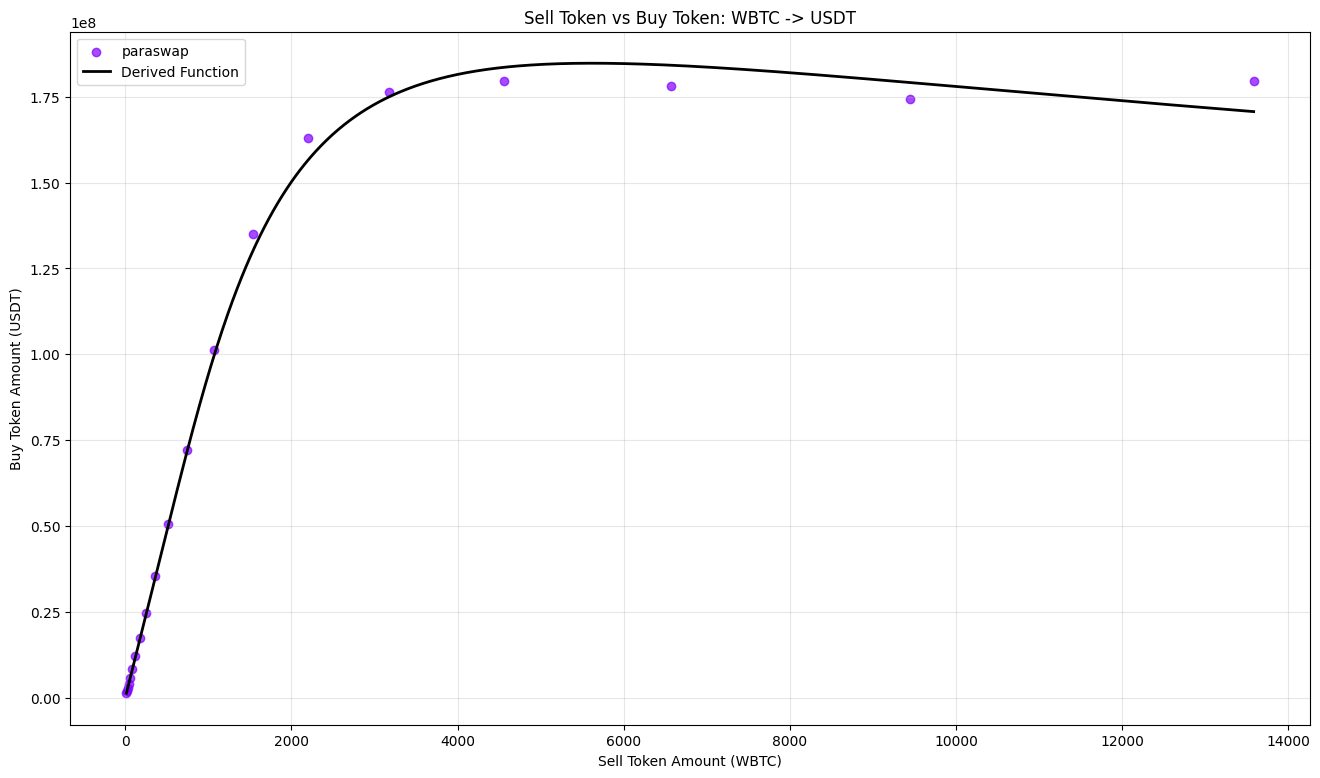


Function parameters:
Exchange Price (r): 97028.000000
k: 18238.618139
c: 1.238565


In [34]:

# Creata a copy of updated_trade_pair_hashmap
updated_trade_pair_hashmap_copy = trade_pair_hashmap.copy()


pair = updated_trade_pair_hashmap_copy["WBTC-USDT"]


def derived_func(x, r, k, c):
    """
    Calculate the value of y based on the given formula.

    Parameters:
        x (float): The value of x in the formula.
        r (float): The value of r in the formula.
        k (float): The value of k in the formula.
        c (float): The value of c in the formula.

    Returns:
        float: The calculated value of y.
    """
    exponent = k * (x ** -c)
    y = (x * r) * (1 - (1/np.exp(exponent)))
    return y

r = pair.exchange_price
k = pair.k
c = pair.c

pair_quotes_df = pair.quotes_df

# Create a new figure with a larger size
plt.figure(figsize=(16, 9))

# Plot scatter points for each dex_aggregator
aggregators = pair_quotes_df['dex_aggregator'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(aggregators)))

sell_token_decimals = pair.sell_token.decimals
buy_token_decimals = pair.buy_token.decimals

for aggregator, color in zip(aggregators, colors):
    df_agg = pair_quotes_df[pair_quotes_df['dex_aggregator'] == aggregator]
    if not df_agg.empty:
        adjusted_sell_amount = df_agg['sell_token_amount'] / (10 ** sell_token_decimals)
        adjusted_buy_amount = df_agg['buy_token_amount'] / (10 ** buy_token_decimals)
        plt.scatter(adjusted_sell_amount, 
                    adjusted_buy_amount, 
                    label=aggregator, color=color, alpha=0.7)
    else:
        print(f"No data for aggregator: {aggregator}")

# Plot the derived function
if not pair_quotes_df.empty:
    x_min = pair_quotes_df['sell_token_amount'].min() / (10 ** sell_token_decimals)
    x_max = pair_quotes_df['sell_token_amount'].max() / (10 ** sell_token_decimals)
    x_range = np.linspace(x_min, x_max, 1000)
    y_derived = derived_func(x_range, r, k, c)
    plt.plot(x_range, y_derived, 'k-', label='Derived Function', linewidth=2)

plt.xlabel(f'Sell Token Amount ({pair.sell_token.symbol})')
plt.ylabel(f'Buy Token Amount ({pair.buy_token.symbol})')
plt.title(f'Sell Token vs Buy Token: {pair.sell_token.symbol} -> {pair.buy_token.symbol}')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

# Print the function parameters
print(f"\nFunction parameters:")
print(f"Exchange Price (r): {r:.6f}")
print(f"k: {k:.6f}")
print(f"c: {c:.6f}")

In [35]:
# Create price mapping
new_price_mapping = {ASSET_UNDER_CONSIDERATION: PRICE_ASSUMPTION}
price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))

# Create asset mapping and get health ratios
asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)

In [36]:
asset_mapping

{'WETH': {'price': 3715.59, 'liquidationThreshold': 0.83},
 'wstETH': {'price': 4402.51, 'liquidationThreshold': 0.81},
 'WBTC': {'price': 82473.8, 'liquidationThreshold': 0.78},
 'USDC': {'price': 0.999451, 'liquidationThreshold': 0.78},
 'DAI': {'price': 1.0, 'liquidationThreshold': 0.77},
 'LINK': {'price': 22.48, 'liquidationThreshold': 0.71},
 'AAVE': {'price': 256.34, 'liquidationThreshold': 0.73},
 'cbETH': {'price': 4026.01, 'liquidationThreshold': 0.79},
 'USDT': {'price': 1.0, 'liquidationThreshold': 0.78},
 'rETH': {'price': 4164.8, 'liquidationThreshold': 0.79},
 'LUSD': {'price': 0.998643, 'liquidationThreshold': 0.77},
 'CRV': {'price': 1.062, 'liquidationThreshold': 0.41},
 'MKR': {'price': 1881.12, 'liquidationThreshold': 0.7},
 'SNX': {'price': 2.77, 'liquidationThreshold': 0.65},
 'BAL': {'price': 3.24, 'liquidationThreshold': 0.59},
 'UNI': {'price': 15.73, 'liquidationThreshold': 0.74},
 'LDO': {'price': 1.82, 'liquidationThreshold': 0.5},
 'ENS': {'price': 33.56461

In [37]:
def construct_new_price_mapping(asset_mapping, 
                                new_price_mapping,
                                total_liquidatable_collateral,
                                total_liquidatable_debt):
    
    output_mapping = {}
    
    # Extract keys from total_liquidatable_collateral and total_liquidatable_debt and add to separate sets
    liquidatable_collateral_assets = set(total_liquidatable_collateral.keys())
    liquidatable_debt_assets = set(total_liquidatable_debt.keys())
    
    # Join liquidatable_collateral_assets and liquidatable_debt_assets and remove duplicates
    liquidatable_assets = liquidatable_collateral_assets.union(liquidatable_debt_assets)    
    
    for asset in liquidatable_assets:
        if asset in new_price_mapping:
            price = new_price_mapping[asset]
            
            output_mapping[asset] = price
        else:
            price = asset_mapping[asset]['price']
            output_mapping[asset] = price
    
    for asset in FLASHLOAN_ASSET_SYMBOLS:
        price = asset_mapping[asset]['price']
        output_mapping[asset] = price
            
    return output_mapping



In [38]:
new_broad_price_mapping = construct_new_price_mapping(asset_mapping, new_price_mapping, total_collateral, total_debt)


In [39]:
updated_trade_pair_hashmap = update_trade_pair_exchange_price(trade_pair_hashmap, new_broad_price_mapping)


In [44]:
liquidation_profits_df = scale_supply_and_create_liquidations(updated_trade_pair_hashmap, 
                                                              asset_mapping, 
                                                              total_collateral, 
                                                              total_debt,
                                                              0.02, 
                                                              3,
                                                              50)


{
    "WETH": 5.627650088905227,
    "WBTC": 15.385444593399997
}
{
    "WETH": 3.988199455332455,
    "USDC": 60695.25740395999,
    "DAI": 5088.243725960027,
    "USDT": 1011763.67565768,
    "UNI": 14.714332432037109,
    "RPL": 45.38939016455154,
    "PYUSD": 8662.49964226,
    "cbBTC": 0.17449242,
    "crvUSD": 101.63369023512541
}
{
    "WETH": 5.627650088905227,
    "WBTC": 15.385444593399997
}
{
    "WETH": 3.988199455332455,
    "USDC": 60695.25740395999,
    "DAI": 5088.243725960027,
    "USDT": 1011763.67565768,
    "UNI": 14.714332432037109,
    "RPL": 45.38939016455154,
    "PYUSD": 8662.49964226,
    "cbBTC": 0.17449242,
    "crvUSD": 101.63369023512541
}
{
    "WETH": 5.627650088905227,
    "WBTC": 15.385444593399997
}
{
    "WETH": 3.988199455332455,
    "USDC": 60695.25740395999,
    "DAI": 5088.243725960027,
    "USDT": 1011763.67565768,
    "UNI": 14.714332432037109,
    "RPL": 45.38939016455154,
    "PYUSD": 8662.49964226,
    "cbBTC": 0.17449242,
    "crvUSD": 101.

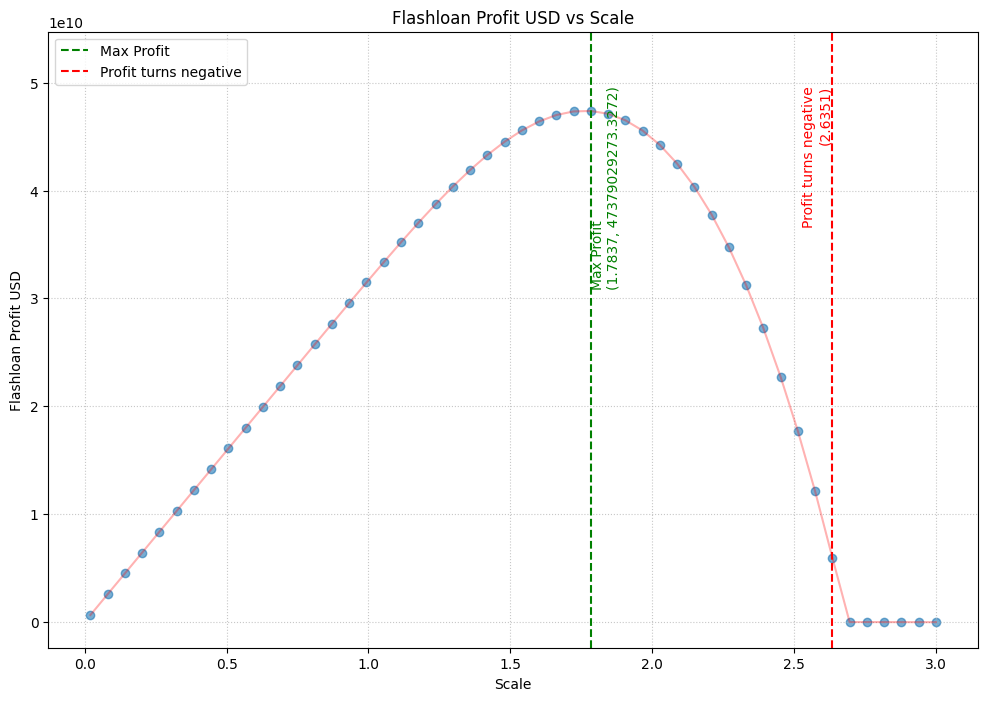

Maximum profit point: Scale = 1.78, Profit = 47379029273.33
Profit turns negative at: Scale = 2.64


In [45]:
# Sort the dataframe by scale
sorted_df = liquidation_profits_df.sort_values('scale')

# Find the point of maximum profit
max_profit_idx = sorted_df['flashloan_profit_usd'].idxmax()
max_profit_x = sorted_df.loc[max_profit_idx, 'scale']
max_profit_y = sorted_df.loc[max_profit_idx, 'flashloan_profit_usd']

# Find the point where profit turns negative
positive_profits = sorted_df[sorted_df['flashloan_profit_usd'] > 0]
if not positive_profits.empty:
    last_positive_idx = positive_profits.index[-1]
    zero_crossing_x = sorted_df.loc[last_positive_idx, 'scale']
    zero_crossing_y = 0
else:
    zero_crossing_x = zero_crossing_y = None

# Create the plot
plt.figure(figsize=(12, 8))
plt.scatter(sorted_df['scale'], sorted_df['flashloan_profit_usd'], alpha=0.6)
plt.plot(sorted_df['scale'], sorted_df['flashloan_profit_usd'], 'r-', alpha=0.3)

# Add vertical lines and annotations
plt.axvline(x=max_profit_x, color='g', linestyle='--', label='Max Profit')
plt.text(max_profit_x, plt.ylim()[1], f'Max Profit\n({max_profit_x:.4f}, {max_profit_y:.4f})', 
         rotation=90, va='top', ha='left', color='g')

if zero_crossing_x:
    plt.axvline(x=zero_crossing_x, color='r', linestyle='--', label='Profit turns negative')
    plt.text(zero_crossing_x, plt.ylim()[1], f'Profit turns negative\n({zero_crossing_x:.4f})', 
             rotation=90, va='top', ha='right', color='r')

# Adjust y-axis to give more space for labels
plt.ylim(plt.ylim()[0], plt.ylim()[1] * 1.1)

plt.xlabel('Scale')
plt.ylabel('Flashloan Profit USD')
plt.title('Flashloan Profit USD vs Scale')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Use scientific notation for y-axis if numbers are very large
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.tight_layout()
plt.show()

# Print the exact values
print(f"Maximum profit point: Scale = {max_profit_x:.2f}, Profit = {max_profit_y:.2f}")
if zero_crossing_x:
    print(f"Profit turns negative at: Scale = {zero_crossing_x:.2f}")
else:
    print("Profit does not turn negative within the given data range.")

---